In [1]:
import sys

sys.path.append("..")

In [2]:
import os
from typing import Tuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torchvision.datasets
import torch.utils.data
import torchvision.transforms.functional as F

from PIL import Image

import transforms
import visualize
import datasets

from brain_segmentation_pytorch.unet import UNet

/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

## Dataset setup

### Transforms

In [3]:
tr_inf = transforms.make_transforms(datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"])
tr_img_inv = transforms.inv_normalize(datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"])

### Dataset loading

In [4]:
dataroot = '../data/'

In [5]:
ds_train = torchvision.datasets.wrap_dataset_for_transforms_v2(torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="train",
    download=False,
    transforms=tr_inf))


In [6]:
ds_val = torchvision.datasets.wrap_dataset_for_transforms_v2(torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="val",
    download=False,
    transforms=tr_inf))

In [7]:
len(ds_train)

1464

In [8]:
img, mask = ds_train[2]

In [9]:
img.shape

torch.Size([3, 256, 256])

In [10]:
img.device

device(type='cpu')

In [11]:
mask.shape

torch.Size([1, 256, 256])

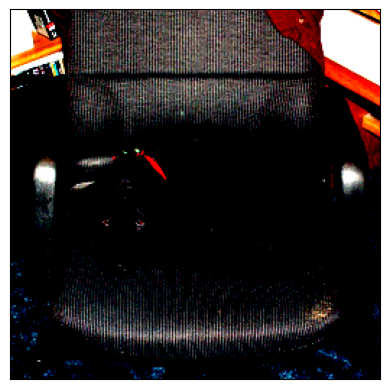

In [12]:
plt.figure()
visualize.imshow_tensor(img, ax=plt.gca())
plt.show()

## Load Model

In [13]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# Model from checkpoint file
def model_from_checkpoint(checkpointfile):
    checkpoint = torch.load(checkpointfile)
    unet_features = checkpoint['model_state_dict']['encoder1.enc1conv1.weight'].size(0)
    model = UNet(
        in_channels=3,
        out_channels=datasets.CLASS_MAX+1,
        init_features=unet_features,
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.eval().to(device)
    return model

In [15]:
model = model_from_checkpoint("../checkpoints/test.chpt.pt")

## Predictions

In [16]:
def topclass_dict(mask: torch.Tensor, k: int=4):
    pred_classes, counts = mask.unique(return_counts=True)
    topcounts, topcounts_idx = torch.topk(counts, min(k, len(counts)))
    #topclasses = pred_classes[topcounts_idx]

    top_k_classpixels = {
        datasets.CLASSNAMES[pred_classes[i].item()] : counts[i].item()
        for i in topcounts_idx
    }

    return top_k_classpixels

In [17]:
def infer_ds_sample(sample: Tuple[torch.Tensor, torch.Tensor], model=model):
    img, mask = sample
    img = img.unsqueeze(0)
    mask = mask[0,:].unsqueeze(0)

    with torch.no_grad():
        pred = model(img.to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred, dim=1)
        
        grid = visualize.make_comparison_grid(img=tr_img_inv(img), prediction=pred_amax, mask=mask)

    top_k_classpixels = topclass_dict(pred_amax)
    p = visualize.imshow_tensor(grid)

    return p, top_k_classpixels


In [18]:
def infer_ds_sample(sample: Tuple[torch.Tensor, torch.Tensor], model=model, fig=None):
    # get current figure if it was not provided
    fig = fig if fig else plt.gcf()

    # take out sample, add singleton batch dimension
    img, mask = sample
    img = img.unsqueeze(0)
    mask = mask[0,:].unsqueeze(0)

    # do prediction
    with torch.no_grad():
        pred = model(img.to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred, dim=1)
        
    # get all unique classes in prediction
    show_classes = set((t.item() for t in pred_amax[0,:].unique()))
    # add all unique classes in mask
    show_classes.union((t.item() for t in mask[0,:].unique()))
    
    _, axs = visualize.plot_prediction_comparison(img=tr_img_inv(img[0,:]), prediction_mask=pred_amax[0,:], target_mask=mask[0,:], fig=fig)
    visualize.make_colormap_legend(ax=plt.gca(), fig=fig, cmap=visualize.cm_tab21, class_names=datasets.CLASSNAMES.values(), only_classes=show_classes)

    top_k_classpixels = topclass_dict(pred_amax)

    return fig, top_k_classpixels


In [19]:
sample = ds_train[2]

### Training Set

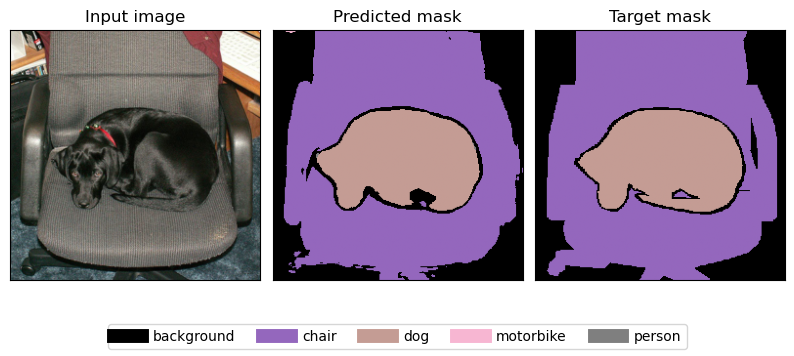

In [20]:
plt.figure(figsize=(10,4))
infer_ds_sample(ds_train[2], model=model)
plt.show()

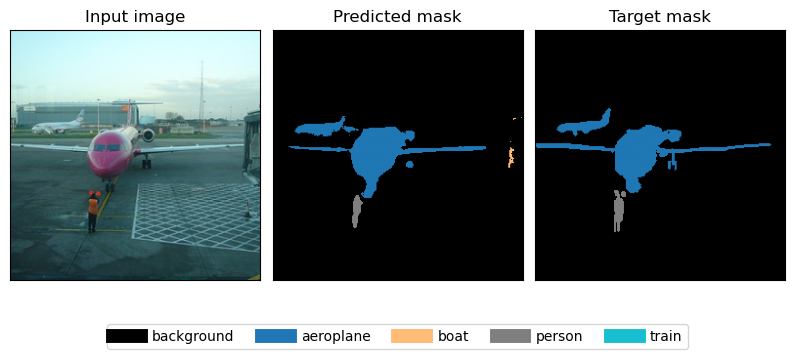

In [21]:
plt.figure(figsize=(10,4))
infer_ds_sample(ds_train[0], model=model)
plt.show()

### Validation Set

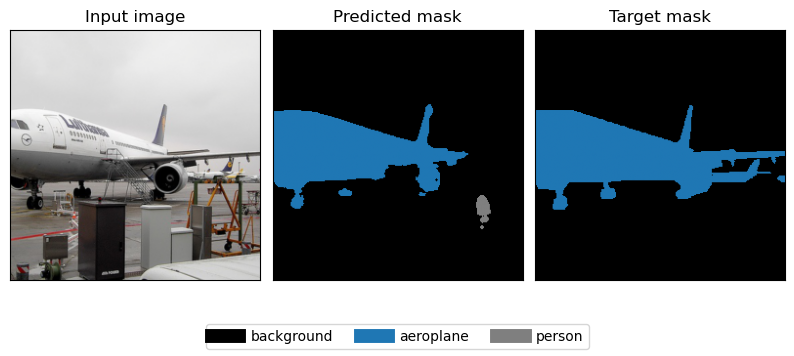

In [22]:
plt.figure(figsize=(10,4))
infer_ds_sample(ds_val[0], model=model)
plt.show()

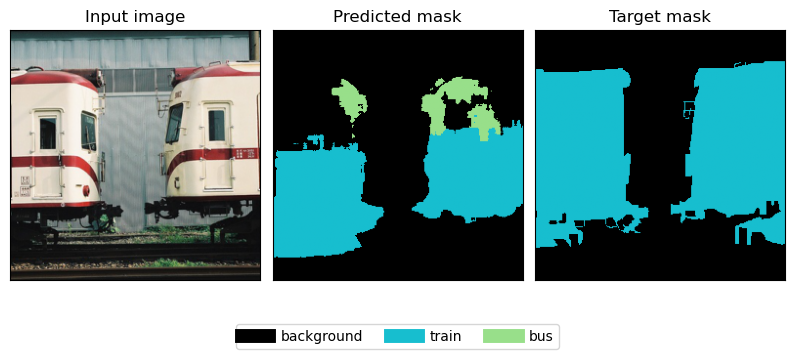

In [23]:
plt.figure(figsize=(10,4))
infer_ds_sample(ds_val[1], model=model)
plt.show()

### Custom Input

In [24]:
def infer_imgfile(path: str, model=model, fig=None):
    # get current figure if it was not provided
    fig = fig if fig else plt.gcf()

    with Image.open(path) as imgfile:
        img = tr_inf(imgfile)

    with torch.no_grad():    
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred.squeeze(0), dim=0)
        
    # get all unique classes in prediction
    show_classes = set((t.item() for t in pred_amax.unique()))
    
    _, axs = visualize.plot_prediction_comparison(
        img=tr_img_inv(img),
        prediction_mask=pred_amax,
        fig=fig
    )
    visualize.make_colormap_legend(
        ax=plt.gca(), fig=fig,
        cmap=visualize.cm_tab21,
        class_names=datasets.CLASSNAMES.values(),
        only_classes=show_classes
    )


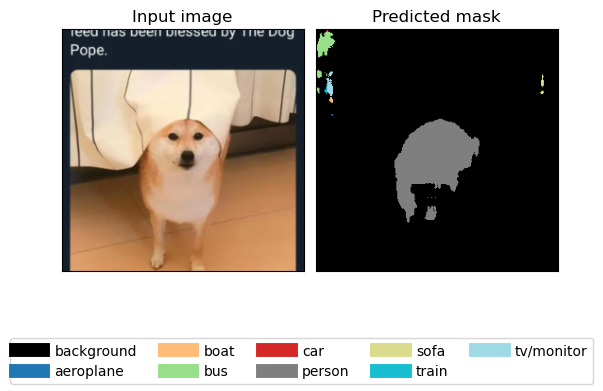

In [25]:
infer_imgfile("../samples/dogpope.jpg", model=model)

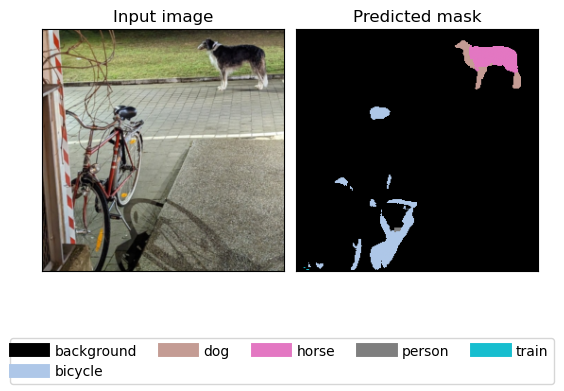

In [26]:
infer_imgfile("../samples/ghost1_cropped.jpg", model=model)

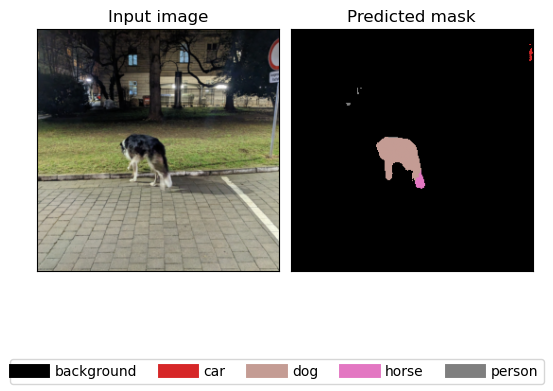

In [27]:
infer_imgfile("../samples/ghost2.jpg", model=model)

### Multiple File input

In [28]:
def infer_and_plot_files(imgfiles, model=model):
    figheight = 4 *len(imgfiles)
    fig = plt.figure(figsize=(8, figheight))
    figs = fig.subfigures(nrows=len(imgfiles))
    for img_idx, imgfile in enumerate(imgfiles):
        infer_imgfile(imgfile, fig=figs[img_idx], model=model)
        figs[img_idx].suptitle(os.path.splitext(os.path.basename(imgfile))[0])

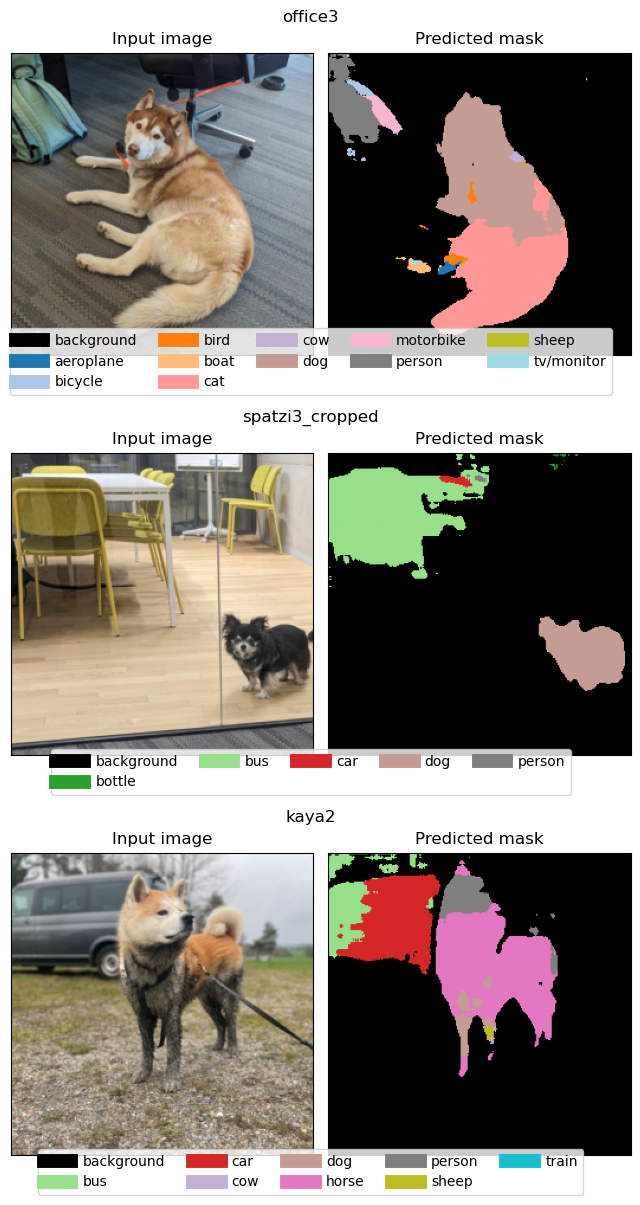

In [29]:
imgfiles = ["../samples/office3.jpg", "../samples/spatzi3_cropped.jpg", "../samples/kaya2.jpeg"]
infer_and_plot_files(imgfiles, model=model)